# The $k$-nearest neighbors (KNN, $k$-NN) algorithm

**Authors**: Joseph Salmon, Alexandre Gramfort, Claire Vernade, Mathurin Massias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import stats
from sklearn import neighbors
from sklearn import datasets
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.extmath import weighted_mode
from sklearn.model_selection import cross_val_score


from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d, ErrorCurve,
                           frontiere_new, LOOCurve)


import seaborn as sns
from matplotlib import rc

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
_ = sns.axes_style()
np.random.seed(42) # fix seed globally

## Data generation

rand_bi_gauss yields two matrices, X for the features and y for the set of labels <br>
Each row of X contains 2 observations distributed either from a Gaussian random variable of parameters mu1, sigma1 (one random half of the matrix) or from a Gaussian random variable of parameters mu2, sigma2 (the other random half of the matrix) <br>
Each row of y contains the labels: 1 for the first distribution or -1 for the second distribution. <br>
<br>
rand_tri_gauss does the same but for 3 distributions (and therefore with 3 labels): it yields two matrices, X for the features and y for the set of labels. <br>
Each row of X contains 2 observations distributed from 1 of 3 Gaussian random variables (first one with parameters mu1, sigma1, second one mu2, sigma2, third one mu3, sigma3) each distribution showing up randomly one one third of rows <br>
Each row of y contains the labels: 1 for the first distribution or 2 for the second distribution, 3 for the third distribution <br>
<br>
For rand_clown, X contains 2 types of rows, each making up half of the total raws randomly, and each type of row having 2 observations from 2 different distributions (the pairs of distributions being the same across one given type of row). <br>
Consequently, y contains 2 labels: 1 for the first type of row (containing 1 pair of 2 distributions given for type 1) and -1 for the other (containing 1 pair of 2 distributions given for type 2). <br>
<br>
rand_checkers yields 2 matrices X and y. <br>
It uses a nested for loop generating 20 iterations to set the features distribution and the label based on the values of the variables i and j.

In [2]:
X1, y1 = rand_bi_gauss(n1=20, n2=20)
X2, y2 = rand_tri_gauss(n1=50, n2=50, n3=50)
X3, y3 = rand_checkers(n1=50, n2=50)
X4, y4 = rand_clown(n1=150, n2=150)

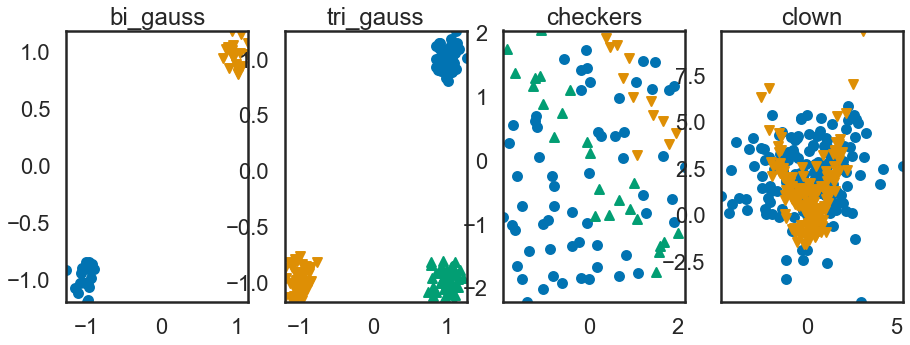

In [3]:
############################################################################
#     Displaying labeled data
############################################################################

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.subplot(141)
plt.title('bi_gauss')
plot_2d(X1, y1)

plt.subplot(142)
plt.title('tri_gauss')
plot_2d(X2, y2)

plt.subplot(143)
plt.title('checkers')
plot_2d(X3, y3)

plt.subplot(144)
plt.title('clown')
plot_2d(X4, y4)

## The $k$-NN algorithm

In [4]:
import timeit
def time_func(func, args, number):
     return timeit.timeit(lambda: func(args), number=number)

In [5]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Home made KNN Classifier class"""
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        dist = metrics.pairwise_distances(X, self.X_)
        sorted_indices = np.argsort(dist, axis=1)
        neighbors_indices = sorted_indices[:, :self.n_neighbors]
        Y_neighbors = self.y_[neighbors_indices]
        mode, _ = stats.mode(Y_neighbors, axis=1)
        return mode.ravel()

# Split data set into training and test
X_train, Y_train = X2[::2], y2[::2]
X_test, Y_test = X2[1::2], y2[1::2]

n_neighbors = 1
timer_n_executions = 1000

# Own implementation
knn = KNNClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)
avg_time = (time_func(knn.predict, X_test, number=timer_n_executions) * 1000.0) / timer_n_executions
print('Our implementation')
print('Average execution time in ms (%i executions): %.3fms' % (timer_n_executions, avg_time))
print('---')
Y_pred = knn.predict(X_test)

# Scikit-learn
sknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
sknn.fit(X_train, Y_train)
avg_time = (time_func(sknn.predict, X_test, number=timer_n_executions) * 1000.0) / timer_n_executions
print('Scikit-learn')
print('Average execution time in ms (%i executions): %.3fms' % (timer_n_executions, avg_time))
print('---')
Y_pred_skl = sknn.predict(X_test)

print(f'All labels match: {np.allclose(Y_pred, Y_pred_skl)}')

plt.ion()

Our implementation
Average execution time in ms (1000 executions): 2.739ms
---
Scikit-learn
Average execution time in ms (1000 executions): 2.843ms
---
All labels match: True


Dataset 1 - all labels match: True
Dataset 2 - all labels match: True
Dataset 3 - all labels match: True
Dataset 4 - all labels match: True


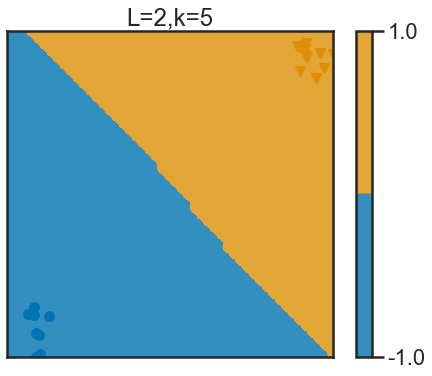

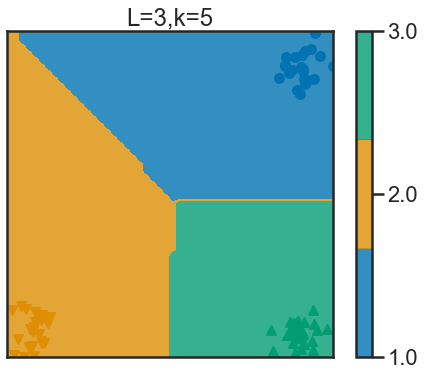

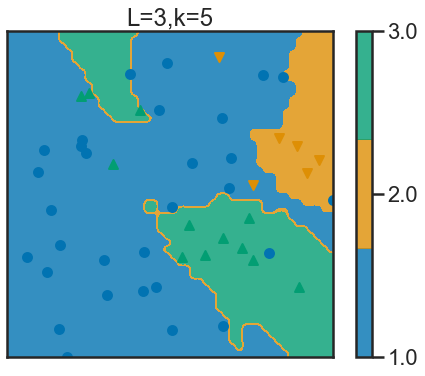

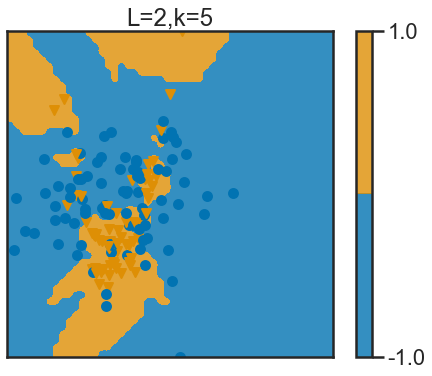

In [6]:
n_neighbors = 5
knn = KNNClassifier(n_neighbors=n_neighbors)
sknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
data = [
  [X1, y1],
  [X2, y2],
  [X3, y3],
  [X4, y4]
]

for i in range(len(data)):
    X, y = data[i]
    X_train, Y_train = X[::2], y[::2]
    X_test, Y_test = X[1::2], y[1::2]
    plt.figure()
    knn.fit(X_train, Y_train)
    sknn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Y_pred_skl = sknn.predict(X_test)
    print(f'Dataset {i + 1} - all labels match: {np.allclose(Y_pred, Y_pred_skl)}')
    n_labels = len(np.unique(y))
    frontiere_new(knn, X_train, Y_train, w=None, step=50, alpha_choice=1, n_labels=n_labels, n_neighbors=n_neighbors)

ValueError: num must be 1 <= num <= 15, not 16

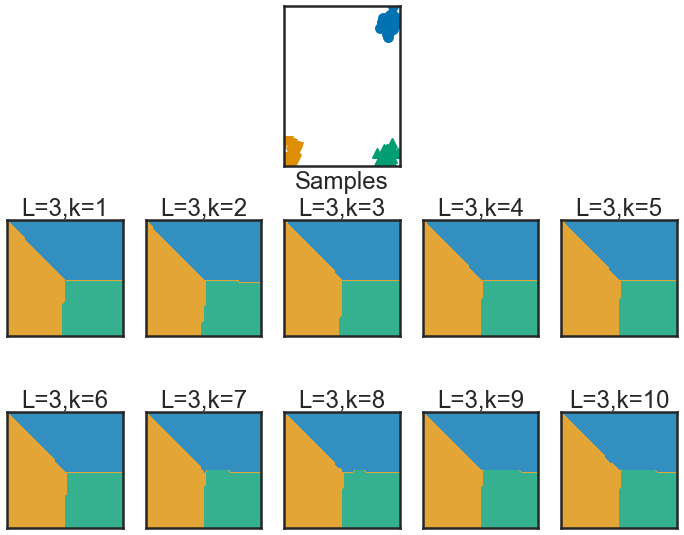

In [7]:
X, y = X2[::2], y2[::2]

plt.figure(3, figsize=(12, 10))
plt.subplot(3, 5, 3)
plot_2d(X, y)
plt.xlabel('Samples')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

for n_neighbors in range(1, len(y)):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)
    plt.subplot(3, 5, 5 + n_neighbors)
    frontiere_new(knn, X, y, w=None, step=50, alpha_choice=1, colorbar=False, samples=False, n_neighbors=n_neighbors)
    plt.draw()

plt.tight_layout()

The lower the number of neighbors, the simpler the frontier. This is not surprising, as we can expect noise to have a larger impact when `k` is smaller.

In [8]:
n_neighbors = 1
X_train, Y_train = X2[::2], y2[::2]

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

train_score = knn.score(X_train, Y_train)
print('Fraction of error on training data: %.1f%%' % ((1 - train_score) * 100.0))
test_score = knn.score(X_test, Y_test)
print('Fraction of error on test data: %.1f%%' % ((1 - test_score) * 100.0))

Fraction of error on training data: 0.0%
Fraction of error on test data: 60.7%


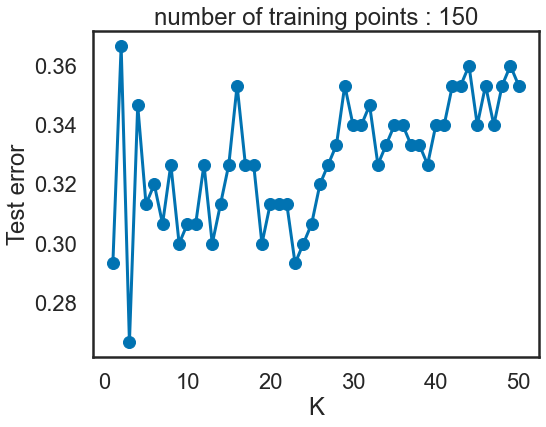

In [9]:
# Scores on left out data

n1 = n2 = 200
sigma = 0.1
data4 = rand_checkers(2 * n1, 2 * n2, sigma)

X_train = X4[::2]
Y_train = y4[::2].astype(int)
X_test = X4[1::2]
Y_test = y4[1::2].astype(int)

# TODO instantiate ErrorCurve with k_range=range(1, 51)
error_curve = ErrorCurve(k_range=range(1, 51))
# TODO fit it, plot it
error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
error_curve.plot()

The best `k` seems to be 2 or 3.

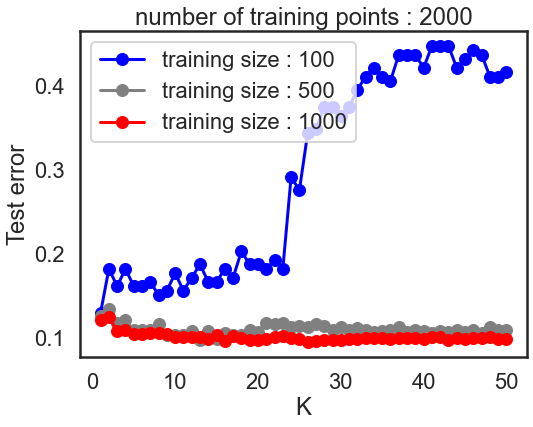

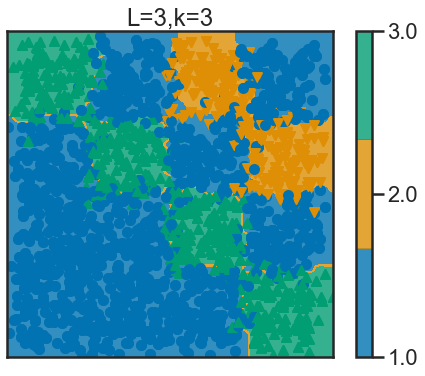

In [11]:
collist = ['blue', 'grey', 'red', 'purple', 'orange', 'salmon', 'black',
           'fuchsia']

sigma = 0.1
plt.figure(5)
range_n_samples = [100, 500, 1000]
niter = len(range_n_samples)
for n in range(niter):
    n1 = n2 = range_n_samples[n]
    X_train, Y_train = rand_checkers(n1, n2, sigma)
    X_test, Y_test = rand_checkers(n1, n2, sigma)
    # TODO fit and plot with color varying from collist
    # TODO instantiate ErrorCurve with k_range=range(1, 51)
    error_curve = ErrorCurve(k_range=range(1, 51))
    # TODO fit it, plot it
    error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
    error_curve.plot(c=collist[n])

plt.legend(["training size : %d" % n for n in range_n_samples],
           loc='upper left')

plt.close(6)
plt.figure(6)
plot_2d(X_train, Y_train)
n_neighbors = 40
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

frontiere_new(knn, X_train, Y_train, w=None, step=50, alpha_choice=1)

What are the pros and cons of this classifier?

On the one side, the KNN classifier is simple to understand and has a high interpretability. It could be used for both regression and classification, even though we only experiment with the classification use case here. It also does not require to make a lot of assumptions on the data.

On the other hand, one of the main drawbacks of the KNN is its computational load when used on large data sets. With `N` observations in the training data set and `p` predictor, it has a `Np` time complexity per query point. It also requires high memory because it needs to store the whole training data.

### Application to the DIGITS dataset

0.9866369710467706


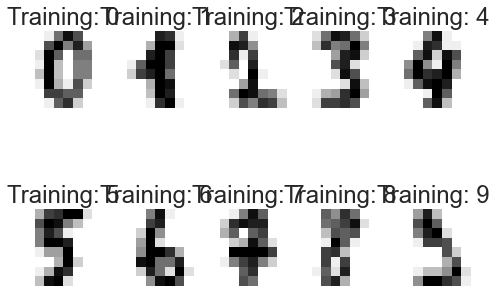

<Figure size 576x432 with 0 Axes>

In [12]:
# test k-NN on digits dataset

# The digits dataset
digits = datasets.load_digits()

for idx, (img, lbl) in enumerate(list(zip(digits.images,
                                          digits.target))[10:20]):
    plt.subplot(2, 5, idx + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % lbl)

n_samples = len(digits.data)

X_train = digits.data[::2]
Y_train = digits.target[::2]
X_test = digits.data[1::2]
Y_test = digits.target[1::2]

plt.figure()
# todo plot histogram of Y_test

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)
score = knn.score(X_test, Y_test)
print(score)

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  1 92  0  0  0  0  0  0]
 [ 0  1  0  0 87  0  0  0  0  0]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  0  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  0  0 91  0  0]
 [ 0  2  0  0  0  0  1  1 82  0]
 [ 0  1  0  0  1  0  0  0  1 88]]


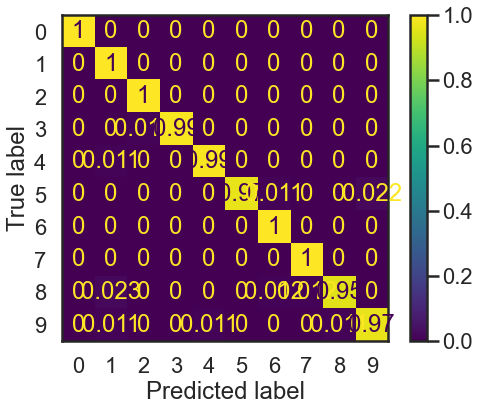

In [13]:
# Compute confusion matrix

Y_pred = knn.predict(X_test)

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
print(conf_mat)

# TODO normalize CM so that each row sums to 1
plot_confusion_matrix(knn, X_test, Y_test, normalize='true');

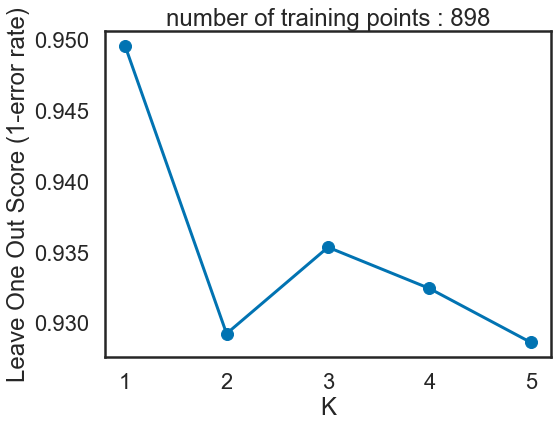

In [14]:
# Estimate k with cross-validation

# Have a look at the class 'LOOCurve', defined in the source file.
# LOO stands for Leave One Out
loo_curve = LOOCurve()
# TODO fit it
loo_curve.fit_curve(X_train, Y_train)
# TODO print cross val scores
scores = cross_val_score(knn, X_train, Y_train)

plt.figure()
# TODO plot curve
loo_curve.plot()

A method to chose the optimal value of `k` would be to vary `k` between 1 and `n`, compute the error rate each time and choose `k` that minimize the error rate.

Here is a possible implementation, using code from the `tp_knn_source.py`:

In [19]:
from sklearn import model_selection

def score_func(X, y, k, n_splits=20, random_state=1):
    loo = model_selection.ShuffleSplit(n_splits=n_splits,
                                       test_size=0.8,
                                       random_state=random_state)
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    scores = model_selection.cross_val_score(estimator=knn,
                                             X=X, y=y,
                                             cv=loo)
    return np.mean(scores)

X_train, Y_train = X2[::2], y2[::2]
best_k, best_score = 1, 0.0

for k in range(1, 15):
    score = score_func(X_train, Y_train, k)
    if score > best_score:
        best_k, best_score = k, score
        
print(best_k)

1


### Weighted $k$-NN classifier

All labels match: False


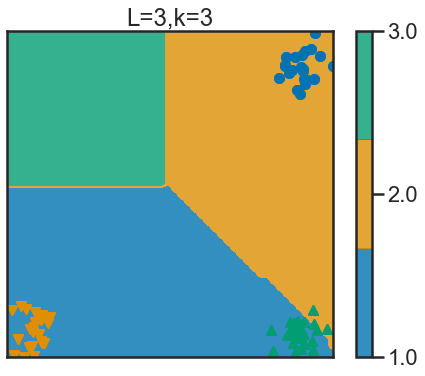

In [25]:
# Implement weights for the kNN classifier

def weights(dist, h=0.1):
    return np.exp((- dist ** 2) / h)

class WKNNClassifier(BaseEstimator, ClassifierMixin):
    """
    Home made KNN Classifier class
    """
    def __init__(self, n_neighbors=1, weights=None):
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        dist = metrics.pairwise_distances(X, self.X_)
        if self.weights is not None:
            dist = self.weights(dist)
        sorted_indices = np.argsort(dist, axis=1)
        neighbors_indices = sorted_indices[:, :self.n_neighbors]
        Y_neighbors = self.y_[neighbors_indices]
        mode, _ = stats.mode(Y_neighbors, axis=1)
        return mode.ravel()


X_train, Y_train = X2[::2], y2[::2]
X_test, Y_test = X2[1::2], y2[1::2]

n_neighbors = 1

wknn = WKNNClassifier(n_neighbors=n_neighbors, weights=weights)
wknn.fit(X_train, Y_train)
Y_pred = wknn.predict(X_test)

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
knn.fit(X_train, Y_train)
Y_pred_skl = knn.predict(X_test)

print(f'All labels match: {np.allclose(Y_pred, Y_pred_skl)}')

plt.figure(4)
plot_2d(X_train, Y_train)
frontiere_new(wknn, X_train, Y_train, w=None, step=50, alpha_choice=1)